In [1]:
import os
%cd ../

/Users/gregoryyampolsky/Downloads/RentEstimateProject


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from src import preprocessing
from src.modeling import Modeler

In [3]:
#read the csv
df = pd.read_csv('data/TrainingSet.csv')
print(df.shape)
df.head()

(274075, 8)


,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built
0,12/17/2024,4800.0,26.257621,-81.711571,4,3.0,2259,2004
1,12/17/2024,3700.0,34.041742,-84.044686,5,6.0,2951,2002
2,12/17/2024,2400.0,33.205474,-96.664503,4,2.0,1788,2000
3,12/17/2024,1770.0,27.756995,-82.648477,3,1.0,944,1955
4,12/17/2024,1995.0,32.627490,-97.328963,3,2.0,1360,2010


In [4]:
final_df = preprocessing.preprocess_data(df)
final_df.head()

Zillow match rate: 28.2% (77364 / 274075)


,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Close Month,Close Year,House Age,Age at Sale,ZHI,DistanceToTransit
0,2024-12-17,4800.0,26.257621,-81.711571,4,3.0,2259,12,2024,20,20,201206.79852,1684.942919
1,2024-12-17,3700.0,34.041742,-84.044686,5,6.0,2951,12,2024,22,22,227984.59051,799.887679
2,2024-12-17,2400.0,33.205474,-96.664503,4,2.0,1788,12,2024,24,24,154772.81875,15612.486925
3,2024-12-17,1770.0,27.756995,-82.648477,3,1.0,944,12,2024,69,69,246634.65976,189.133627
4,2024-12-17,1995.0,32.627490,-97.328963,3,2.0,1360,12,2024,14,14,154772.81875,760.209205


In [5]:
target_col = "Close Price"  
Modeler=Modeler(final_df, target_col)
Modeler.train_test_split(0.3)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


models = {
    #linear rergresion
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
        }
    },
    #decision tree 
    'decision_tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]  
        }   
    },
    #hist gradient boosting
    'HistGradientBoostingRegressor': {
        'model': HistGradientBoostingRegressor(random_state=42),
        'params': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_leaf': [2, 5, 10]  
        }   
    },
    #xgboost
    'XGBoost': { 
        'model': XGBRegressor(
            tree_method='hist',
            random_state=42,
            n_estimators=500,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1
        ),
        'params': {
            'model__objective':['reg:squarederror','reg:pseudohubererror'],
            'model__max_depth': [4, 6, 8],
            'model__min_child_weight': [1, 3],
            'model__reg_lambda': [0, 1, 10]
        }
    },
    #ANN 
    'ANN': {
        'model': MLPRegressor(random_state=42, max_iter=400,early_stopping=True,n_iter_no_change=5, tol=1e-3),
        'params': {
            'model__hidden_layer_sizes': [(64,), (64, 32)],
            'model__activation': ['relu'],
            'model__learning_rate_init': [1e-3, 5e-4],
            'model__alpha': [1e-4, 1e-3],
            'model__batch_size': [128]
        }
    }
}
results = Modeler.model_evals(models=models)
results



  0%|          | 0/5 [00:00<?, ?it/s]

Training LinearRegression...


/Users/gregoryyampolsky/Downloads/RentEstimateProject/src/modeling.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results_df = pd.concat([self.results_df, new_row], ignore_index=True)
 20%|██        | 1/5 [00:01<00:07,  1.92s/it]

________________________________________
Training decision_tree...


 40%|████      | 2/5 [00:08<00:14,  4.79s/it]

________________________________________
Training HistGradientBoostingRegressor...


 60%|██████    | 3/5 [00:16<00:12,  6.10s/it]

________________________________________
Training XGBoost...


 80%|████████  | 4/5 [00:53<00:18, 18.16s/it]

________________________________________
Training ANN...


100%|██████████| 5/5 [01:43<00:00, 20.77s/it]

________________________________________


,Model Name,Best Parameters,Training_Latency,Train_MSE,Test_MSE,TrainR2,TestR2
3,XGBoost,"{'model__max_depth': 8, 'model__min_child_weig...",1.732170,100635.161459,170650.630977,0.849041,0.744115
2,HistGradientBoostingRegressor,"{'model__max_depth': 10, 'model__min_samples_l...",2.094353,177240.118644,194731.490340,0.734129,0.708007
4,ANN,"{'model__activation': 'relu', 'model__alpha': ...",12.953836,228514.288358,233730.194256,0.657214,0.649530
1,decision_tree,"{'model__max_depth': 10, 'model__min_samples_s...",1.017930,200359.849158,248745.509593,0.699448,0.627015
0,LinearRegression,{},0.334316,386500.769452,380832.489156,0.420225,0.428955


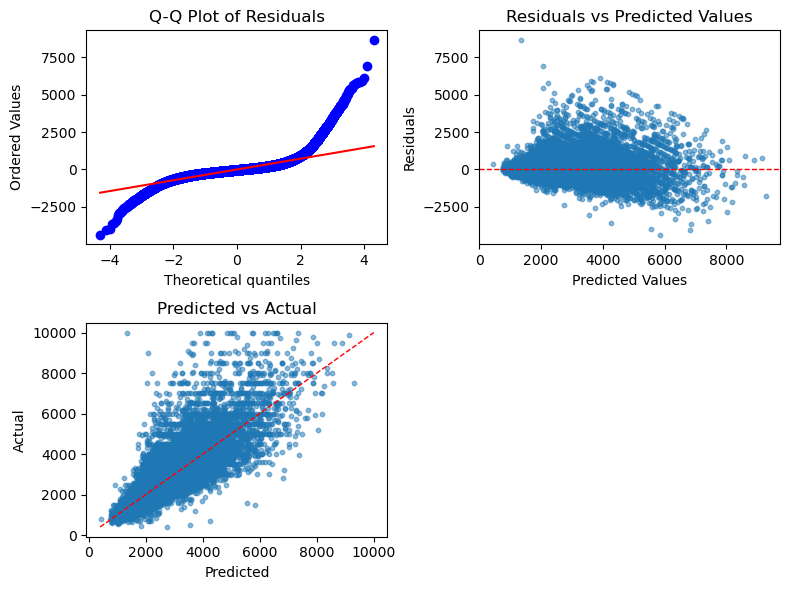

In [7]:
# Compact diagnostics: 2 plots on the first row, 1 on the next
import scipy.stats as stats
import matplotlib.pyplot as plt

best_model = Modeler.best_model
y_pred = best_model.predict(Modeler.X_test)
residuals = Modeler.y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

# Q-Q plot (top-left)
stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title("Q-Q Plot of Residuals")

# Residuals vs Predicted (top-right)
ax2.scatter(y_pred, residuals, alpha=0.5, s=10)
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_xlabel("Predicted Values")
ax2.set_ylabel("Residuals")
ax2.set_title("Residuals vs Predicted Values")

# Predicted vs Actual (bottom-left)
ax3.scatter(y_pred, Modeler.y_test, alpha=0.5, s=10)
low = float(min(Modeler.y_test.min(), y_pred.min()))
high = float(max(Modeler.y_test.max(), y_pred.max()))
ax3.plot([low, high], [low, high], 'r--', linewidth=1)
ax3.set_xlabel("Predicted")
ax3.set_ylabel("Actual")
ax3.set_title("Predicted vs Actual")

# Hide unused bottom-right subplot
ax4.axis('off')

plt.tight_layout()
plt.show()

In [8]:
Modeler.save_models()

Models saved to models/
Model results saved to models/model_results.csv


In [9]:
Modeler.train_final_model()

Final model saved to models/final_model.joblib


In [10]:
# Load final (best) model from disk and generate predictions on test set
import os, joblib
from pathlib import Path
from datetime import datetime
import pandas as pd
from src import preprocessing

test_path='data/TestSet.csv'

print(f"Reading test data from: {test_path}")
raw_test_df = pd.read_csv(test_path)
print("Raw test shape:", raw_test_df.shape)

# Preprocess test data (same function used for training)
processed_test_df = preprocessing.preprocess_data(raw_test_df)
print("Processed test shape:", processed_test_df.shape)

# Identify best model name from results

best_pipeline = joblib.load('models/final_model.joblib')

# Predict
preds = best_pipeline.predict(processed_test_df.drop('X'))

# Assemble output
output_df = raw_test_df.copy()
output_df['Predicted Close Price'] = preds
export_dir = Path('data/exports')
export_dir.mkdir(parents=True, exist_ok=True)
stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
export_file = export_dir / f"final_predictions_{stamp}.csv"
output_df.to_csv(export_file, index=False)
print(f"Predictions written to {export_file} (rows={len(output_df)})")

Reading test data from: data/TestSet.csv
Raw test shape: (10000, 6)


KeyError: 'Close Date'